In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data

from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

# Uncertainty

## Types of uncertainty

### Epistemic uncertainty

### Aleatory uncertainty





# Some existing methods for modelling uncertainty

## Monte Carlo Dropout

## Distributional Parameter Learning

## Ensemble Averaging

## Dropout Ensembles

## Quantile Regression


# Uncertainty modelling example

## Function

$$ y_i = f(x_i) + \epsilon_i, \hspace{1cm} \epsilon_i \sim \mathcal{N}(0,\sigma^2)$$


In [241]:
N_SAMPLES = 30
SIGMA = 1  # Data standard deviation
BATCH_SIZE = 32

In [242]:
np.random.seed(42)

In [243]:
# Data generating function
def f(x, sigma):
    y = 2 * np.sin(x + 0.5) + 3 * np.cos(0.7 * x) #  + (0.1 * x) ** 3
    eps = np.random.normal(loc=0, scale=sigma)
    return y + eps

In [244]:
# Training data
x_1 = np.random.uniform(-10, -5, size=N // 2)
x_2 = np.random.uniform(0, 5, size=N // 2)
x_train = np.concatenate([x_1, x_2])
y_train = f(x_train, sigma=SIGMA)
dataset_train = torch.utils.data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE)

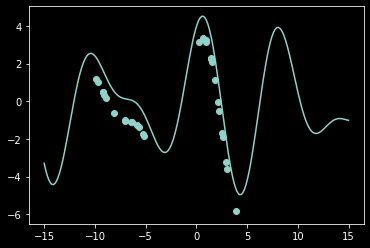

In [245]:
x_plot = np.linspace(-15, 15, num=200)
fig, ax = plt.subplots(1, 1)
ax.plot(x_plot, f(x_plot, sigma=0), label='Data generating function')
ax.scatter(x_train, y_train, label='Training data')

In [ ]:
def gaussian_nll(mu_true, mu_pred, sigma_pred):
    return np.log(sigma_pred ** 2) / 2 + ((mu_true - mu_pred) ** 2) / (2 * sigma_pred ** 2)

In [208]:
class GaussianNLLLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, mu_true, mu_pred, logvar_pred):
        var_pred = logvar_pred.exp()
        return torch.sum(var_pred.log() / 2 + (mu_true - mu_pred).pow(2) / (2 * var_pred))

In [211]:
class DPLModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(1, 10)
        self.act1 = nn.ELU()
        self.lin2 = nn.Linear(10, 2)

    def forward(self, x):
        x = self.lin1(x)
        x = self.act1(x)
        x = self.lin2(x)
        mu = x[..., 0]
        logvar = x[..., 1]
        return mu, logvar

In [212]:
model = DPLModel()
model.to(device)

loss = GaussianNLLLoss()
loss.to(device)

optimizer = optim.Adam(model.parameters, lr=3e-4)

for x_batch, y_batch in dataloader_train:
    x_batch.to(device)
    y_batch.to(device)



NameError: name 'moedl' is not defined